# Entrenamiento del modelo

In [16]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# === CONFIGURACIÓN DEL DATASET ===
# Cambiar aquí para elegir Netflix o Goodreads
DATASET = 'netflix'  # o 'goodreads'

if DATASET == 'netflix':
    NUM_ITEMS = 752
    train_path = 'data/train/netflix8_train.df'
    test_path = 'data/test_users/netflix8_test.json'
else:
    NUM_ITEMS = 472
    train_path = 'data/train/goodreads8_train.df'
    test_path = 'data/test_users/goodreads8_test.json'

NUM_GROUPS = 8

Using device: cpu


In [10]:
# Cargar datos de entrenamiento
from src.data.load_data import load_training_data

df_train = load_training_data(dataset='netflix')

In [11]:
# Crear dataset
from src.data.preprocessing import create_dt_dataset, validate_preprocessing

trajectories = create_dt_dataset(df_train)
validate_preprocessing(trajectories)

In [12]:
from src.data.dataset import RecommendationDataset
from torch.utils.data import DataLoader

dataset = RecommendationDataset(trajectories, context_length=20)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Verificar un batch
batch = next(iter(loader))
print(f"Keys: {batch.keys()}")
print(f"States shape: {batch['states'].shape}")  # (64, 20)

Keys: dict_keys(['states', 'actions', 'rtg', 'timesteps', 'groups', 'targets'])
States shape: torch.Size([64, 20])


In [13]:
# Creamos un modelo
from src.models.decision_transformer import DecisionTransformer

model = DecisionTransformer(
    num_items=752,
    num_groups=8,
    hidden_dim=128,
    n_layers=3,
    n_heads=4
)

print(f"Parámetros totales: {sum(p.numel() for p in model.parameters())}")
# Debería ser ~10-20M parámetros

Parámetros totales: 831728


In [14]:
# Entrnamiento básico
from src.training.trainer import train_decision_transformer

train, history = train_decision_transformer(
    model=model,
    train_loader=loader,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-4),
    device=device,
    num_epochs=50
)

Epoch 1/50:
  Train Loss: 6.6250
Epoch 2/50:
  Train Loss: 6.6239
Epoch 3/50:
  Train Loss: 6.6237
Epoch 4/50:
  Train Loss: 6.6237
Epoch 5/50:
  Train Loss: 6.6235
Epoch 6/50:
  Train Loss: 6.6236
Epoch 7/50:
  Train Loss: 6.6235
Epoch 8/50:
  Train Loss: 6.6234
Epoch 9/50:
  Train Loss: 6.6234
Epoch 10/50:
  Train Loss: 6.6233
Epoch 11/50:
  Train Loss: 6.6233
Epoch 12/50:
  Train Loss: 6.6231
Epoch 13/50:
  Train Loss: 6.6231
Epoch 14/50:
  Train Loss: 6.6231
Epoch 15/50:
  Train Loss: 6.6231
Epoch 16/50:
  Train Loss: 6.6230
Epoch 17/50:
  Train Loss: 6.6230
Epoch 18/50:
  Train Loss: 6.6230
Epoch 19/50:
  Train Loss: 6.6230
Epoch 20/50:
  Train Loss: 6.6229
Epoch 21/50:
  Train Loss: 6.6229
Epoch 22/50:
  Train Loss: 6.6229
Epoch 23/50:
  Train Loss: 6.6228
Epoch 24/50:
  Train Loss: 6.6228
Epoch 25/50:
  Train Loss: 6.6228
Epoch 26/50:
  Train Loss: 6.6227
Epoch 27/50:
  Train Loss: 6.6227
Epoch 28/50:
  Train Loss: 6.6228
Epoch 29/50:
  Train Loss: 6.6226
Epoch 30/50:
  Train Lo

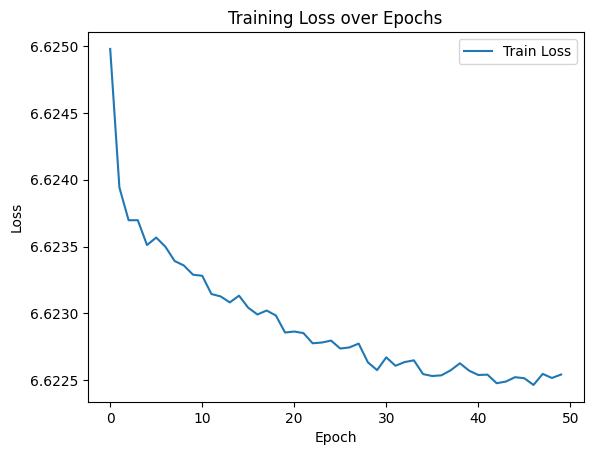

In [15]:
import matplotlib.pyplot as plt
plt.plot(history['train_loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

## También podemos analizar los modelos que va generando el script train.py

In [8]:
import pickle
import os

# Ruta relativa desde el notebook (que está en /notebooks/)
loss_path = 'results/logs/history_netflix.pkl'

with open(loss_path, 'rb') as f:
    loss = pickle.load(f)

print(loss.keys())
print(f"Train loss: {loss['train_loss']}")

dict_keys(['train_loss'])
Train loss: [6.625495222091675, 6.624167854309082, 6.623926692962646, 6.623801065444947, 6.623828845977783, 6.623721328735352, 6.623528129577637, 6.623515775680542, 6.623417348861694, 6.62335343170166, 6.623416130065918, 6.623187482833862, 6.623291990280151, 6.623125444412231, 6.623088550567627, 6.623073347091675, 6.623092239379883, 6.623069404602051, 6.62296270942688, 6.622925281524658, 6.622892757415771, 6.6229823799133305, 6.622879846572876, 6.622793466567993, 6.622801567077636, 6.622789075851441, 6.62270389175415, 6.622744335174561, 6.622752700805664, 6.6227652397155765, 6.622758934020996, 6.622660238265992, 6.622686836242676, 6.622616979598999, 6.622613590240478, 6.622620792388916, 6.622660701751709, 6.622549053192139, 6.6225535049438475, 6.6226205673217775, 6.622494060516358, 6.62256886100769, 6.62262105178833, 6.622581747055054, 6.622525966644287, 6.622541885375977, 6.622428632736206, 6.622531742095947, 6.622461849212646, 6.622543775558472]


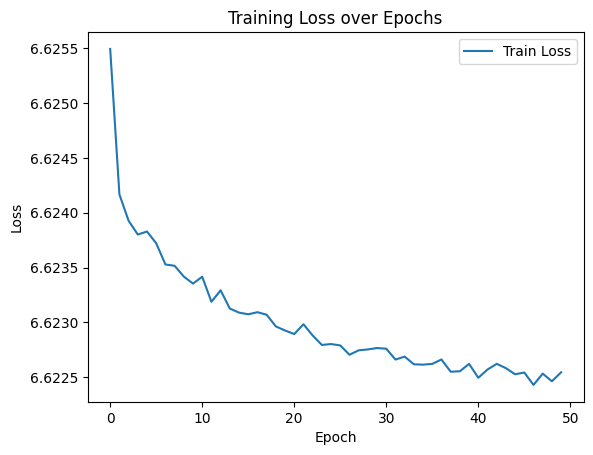

In [10]:
# Graficamos la pérdida de entrenamiento
import matplotlib.pyplot as plt

plt.plot(loss['train_loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()